In [2]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
from google.colab import output
current_dir=os.getcwd()

In [2]:
!unzip drive/MyDrive/animals.zip
output.clear()

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D,LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy,sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix
import os
import glob
import shutil
import random
from keras.models import Model
import pickle
from keras.applications.vgg16 import preprocess_input

from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
import joblib
from joblib import Parallel, delayed

NOW COLLECTING ALL CLASSES OF ANIMALS WHOSE PICTURES ARE AVAILABLE

In [4]:
classes_=[]
for i in os.listdir('animals'):
    classes_.append(i)

NOW MAKING DIRECTORIES AND COLLECTING DATA FOR TRAIN,VALIDATION AND TESTING

In [5]:
# os.chdir('content')
if os.path.isdir('test') is False:
    for animal in classes_:
        os.makedirs('train/'+animal)
        os.makedirs('valid/'+animal)
        os.makedirs('test/'+animal)
        for c in random.sample(glob.glob('animals/'+animal+'/*'),50):
            shutil.move(c,'train/'+animal)
        for c in random.sample(glob.glob('animals/'+animal+'/*'),5):
            shutil.move(c,'valid/'+animal)
        for c in random.sample(glob.glob('animals/'+animal+'/*'),5):
            shutil.move(c,'test/'+animal)

In [6]:
train_path='train'
valid_path='valid'
test_path='test'

GENERATING IMAGE DATA

In [7]:
train_batches=ImageDataGenerator(
    rescale=1./255
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=train_path,target_size=(224,224),classes=classes_,batch_size=10
    )
valid_batches=ImageDataGenerator(
    rescale=1./255
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=valid_path,target_size=(224,224),classes=classes_,batch_size=10
    )
test_batches=ImageDataGenerator(
    rescale=1./255
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=test_path,target_size=(224,224),classes=classes_,batch_size=10,shuffle=False
    )

Found 4500 images belonging to 90 classes.
Found 450 images belonging to 90 classes.
Found 450 images belonging to 90 classes.


LETS VISUALIZE THE IMAGE DATA

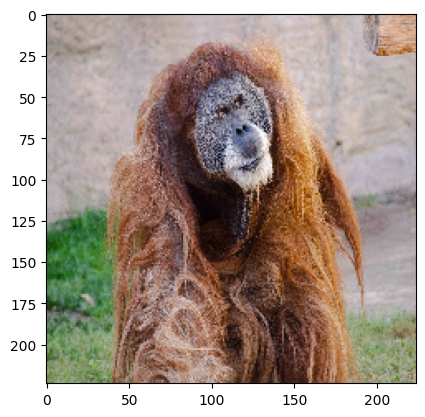

In [109]:
plt.imshow(train_batches[0][0][1])

WE WILL BE TRAINING OUR MODEL FOR 20 EPOCHS, AND SAVE THE BEST MODEL. WE WILL RUN TRAIN STATEMENT UNLESS WE GET SATISFACTORY RESULT

In [8]:
early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 2)  #'''min_delta = 1,patience = 20,'''
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [9]:
def build_discriminator():

  model=Sequential([
      Conv2D(32,4,input_shape=(224,224,3)),
      Dropout(0.3),

      Conv2D(64,5),
      Dropout(0.3),

      Flatten(),

      Dense(90,activation='softmax')
  ])

  return model

In [10]:
discriminator=build_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 221, 221, 32)      1568      
                                                                 
 dropout (Dropout)           (None, 221, 221, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 217, 217, 64)      51264     
                                                                 
 dropout_1 (Dropout)         (None, 217, 217, 64)      0         
                                                                 
 flatten (Flatten)           (None, 3013696)           0         
                                                                 
 dense (Dense)               (None, 90)                271232730 
                                                                 
Total params: 271285562 (1.01 GB)
Trainable params: 2712

In [11]:
discriminator.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
discriminator.fit(x=train_batches,validation_data=valid_batches,batch_size=10,epochs=10,steps_per_epoch=100,callbacks=[early_stopping,cp_callback],verbose=2)

Epoch 1/10

Epoch 1: saving model to training_1/cp.ckpt
100/100 - 40s - loss: 10.4786 - accuracy: 0.0480 - val_loss: 4.4073 - val_accuracy: 0.1000 - 40s/epoch - 401ms/step
Epoch 2/10

Epoch 2: saving model to training_1/cp.ckpt
100/100 - 32s - loss: 3.8919 - accuracy: 0.2280 - val_loss: 4.2701 - val_accuracy: 0.1000 - 32s/epoch - 317ms/step
Epoch 3/10

Epoch 3: saving model to training_1/cp.ckpt
100/100 - 44s - loss: 3.0966 - accuracy: 0.3910 - val_loss: 4.0863 - val_accuracy: 0.1622 - 44s/epoch - 444ms/step
Epoch 4/10

Epoch 4: saving model to training_1/cp.ckpt
100/100 - 35s - loss: 2.6161 - accuracy: 0.4850 - val_loss: 4.0387 - val_accuracy: 0.1556 - 35s/epoch - 351ms/step
Epoch 5/10

Epoch 5: saving model to training_1/cp.ckpt
100/100 - 47s - loss: 2.2248 - accuracy: 0.5890 - val_loss: 3.9187 - val_accuracy: 0.1778 - 47s/epoch - 474ms/step
Epoch 6/10

Epoch 6: saving model to training_1/cp.ckpt
100/100 - 38s - loss: 1.6398 - accuracy: 0.6800 - val_loss: 3.8256 - val_accuracy: 0.224

THE AMOUNT OF IMAGE DATA WE HAVE, THIS RESULT IS NOT SATISFACTORY. ON TOP OF THAT, THE MODEL CONSUMES EXCESSIVE RESOURCES, SO NOT FEASIBLE EITHER

----------------------FINETUNING XCEPTION MODEL----------------------

In [113]:
x_base_model = Xception(input_shape = (224,224,3),  weights='imagenet',include_top=False)
xception_model=Sequential()
xception_model.add(x_base_model)
xception_model.add(GlobalAveragePooling2D())
xception_model.add(Dropout(0.3))
xception_model.add(Dense(90, activation='softmax'))
xception_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 90)                184410    
                                                                 
Total params: 21045890 (80.28 MB)
Trainable params: 20991362 (80.08 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [114]:
checkpoint_path = "drive/MyDrive/ML_CKPT/Xception/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
xception_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
# xception_model.load_weights(checkpoint_path)

In [115]:
xception_model.fit(x=train_batches,validation_data=valid_batches,batch_size=10,epochs=25,callbacks=[early_stopping,cp_callback],steps_per_epoch=100,verbose=2)

Epoch 1/25

Epoch 1: saving model to drive/MyDrive/ML_CKPT/Xception/cp.ckpt
100/100 - 45s - loss: 4.0026 - accuracy: 0.2040 - val_loss: 2.7008 - val_accuracy: 0.5089 - 45s/epoch - 449ms/step
Epoch 2/25

Epoch 2: saving model to drive/MyDrive/ML_CKPT/Xception/cp.ckpt
100/100 - 18s - loss: 2.5871 - accuracy: 0.5650 - val_loss: 1.4047 - val_accuracy: 0.7089 - 18s/epoch - 183ms/step
Epoch 3/25

Epoch 3: saving model to drive/MyDrive/ML_CKPT/Xception/cp.ckpt
100/100 - 19s - loss: 1.5758 - accuracy: 0.7270 - val_loss: 0.9443 - val_accuracy: 0.7911 - 19s/epoch - 191ms/step
Epoch 4/25

Epoch 4: saving model to drive/MyDrive/ML_CKPT/Xception/cp.ckpt
100/100 - 19s - loss: 1.0019 - accuracy: 0.8170 - val_loss: 0.7208 - val_accuracy: 0.8178 - 19s/epoch - 186ms/step
Epoch 5/25

Epoch 5: saving model to drive/MyDrive/ML_CKPT/Xception/cp.ckpt
100/100 - 21s - loss: 0.7293 - accuracy: 0.8620 - val_loss: 0.5401 - val_accuracy: 0.8667 - 21s/epoch - 212ms/step
Epoch 6/25

Epoch 6: saving model to drive/My

-------------------------- INCEPTIONv3 FINETUNING----------------------

In [125]:
checkpoint_path = "drive/MyDrive/ML_CKPT/InceptionV3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 25,restore_best_weights = True,verbose = 2)  #'''min_delta = 1,patience = 20,'''


In [126]:
base_model = InceptionV3(input_shape = (224,224,3),  weights='imagenet',include_top=False)
Inception_model=Sequential()
Inception_model.add(base_model)
Inception_model.add(GlobalAveragePooling2D())
Inception_model.add(Dropout(0.3))
Inception_model.add(Dense(90, activation='softmax'))
Inception_model.summary()
Inception_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_15 (Dropout)        (None, 2048)              0         
                                                                 
 dense_13 (Dense)            (None, 90)                184410    
                                                                 
Total params: 21987194 (83.87 MB)
Trainable params: 21952762 (83.74 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [36]:
Inception_model.load_weights(checkpoint_path)
temp=Inception_model

In [127]:
Inception_model.fit(x=train_batches,validation_data=valid_batches,batch_size=10,epochs=30,callbacks=[early_stopping,cp_callback],steps_per_epoch=100,verbose=2)

Epoch 1/30

Epoch 1: saving model to drive/MyDrive/ML_CKPT/InceptionV3/cp.ckpt
100/100 - 52s - loss: 3.7245 - accuracy: 0.2170 - val_loss: 1.9670 - val_accuracy: 0.5556 - 52s/epoch - 521ms/step
Epoch 2/30

Epoch 2: saving model to drive/MyDrive/ML_CKPT/InceptionV3/cp.ckpt
100/100 - 14s - loss: 2.0996 - accuracy: 0.5400 - val_loss: 1.0872 - val_accuracy: 0.7156 - 14s/epoch - 140ms/step
Epoch 3/30

Epoch 3: saving model to drive/MyDrive/ML_CKPT/InceptionV3/cp.ckpt
100/100 - 15s - loss: 1.3147 - accuracy: 0.7040 - val_loss: 0.9086 - val_accuracy: 0.7467 - 15s/epoch - 145ms/step
Epoch 4/30

Epoch 4: saving model to drive/MyDrive/ML_CKPT/InceptionV3/cp.ckpt
100/100 - 15s - loss: 0.8759 - accuracy: 0.8060 - val_loss: 0.7443 - val_accuracy: 0.7933 - 15s/epoch - 145ms/step
Epoch 5/30

Epoch 5: saving model to drive/MyDrive/ML_CKPT/InceptionV3/cp.ckpt
100/100 - 14s - loss: 0.7631 - accuracy: 0.8040 - val_loss: 0.6805 - val_accuracy: 0.8111 - 14s/epoch - 144ms/step
Epoch 6/30

Epoch 6: saving mo

In [116]:
pred=xception_model.predict(test_batches)

45/45 [==============================] - 4s 68ms/step


In [118]:
pred.shape

(450, 90)

rat
rat


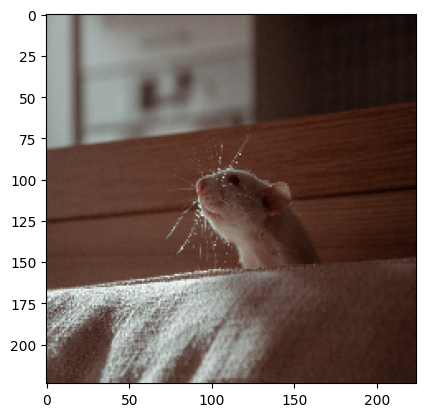

In [119]:
k=5
plt.imshow(test_batches[0][0][k])
print(classes_[np.argmax(pred[k])])
print(classes_[np.argmax(test_batches[0][1][k])])

In [124]:
model_json = xception_model.to_json()
with open("drive/MyDrive/ML_CKPT/Xception/model.json", "w") as json_file:
    json_file.write(model_json)
xception_model.save_weights("drive/MyDrive/ML_CKPT/Xception/model.h5")
print("Saved model to disk")

Saved model to disk
